# Proteomics visualizations
In this notebook, we'll visualize our differentially abundant proteins and perform set operations to identify candidate proteins. We'll then compare these results to the transcriptomics to try and further narrow down meaningful candidate genes.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from upsetplot import from_contents, plot, UpSet
from os import listdir
from os.path import splitext
from collections import defaultdict
from itertools import combinations
import warnings
import json

## Read in the data

In [3]:
two_vs_21 = pd.read_csv('../data/proteomics/2_vs_21_CORRECT_ORDER_de_results_median_permutation_test.csv', header=4)
two_vs_21.head()

,#,Visible?,Starred?,Identified Proteins (5249),Accession Number,Alternate ID,Molecular Weight,Protein Grouping Ambiguity,Permutation Test (p-value) Benjamini-Hochberg (p < 0.00297),Log? Fold Change by Category (Set 2 / Set 21),...,21D,Std Dev Log? Fold Change(21D),40A,Std Dev Log? Fold Change(40A),40B,Std Dev Log? Fold Change(40B),40C,Std Dev Log? Fold Change(40C),40D,Std Dev Log? Fold Change(40D)
0,1,True,Empty,Cluster of Ribulose bisphosphate carboxylase l...,O03042 [2],rbcL,53 kDa,True,0.22,0.02,...,-0.0568,0.243706,0.0446,0.254799,-0.0373,0.273446,0.0432,0.257441,-0.0526,0.239898
1,2,True,Empty,Cluster of Ribulose bisphosphate carboxylase s...,B3H5S2 [2],RBCS3B,21 kDa,True,0.46,-0.06,...,0.0599,0.275499,0.1184,0.238075,0.0576,0.295961,0.0024,0.241662,0.0181,0.257044
2,3,True,Empty,"ATP synthase subunit beta, chloroplastic OS=Ar...",P19366,atpB,54 kDa,True,0.84,0.01,...,-0.0304,0.261425,0.0287,0.237563,-0.1041,0.262003,0.0041,0.257266,-0.0169,0.225745
3,4,True,Empty,Cluster of Oxygen-evolving enhancer protein 1-...,P23321 [2],PSBO1,35 kDa,True,0.71,0.06,...,0.0221,0.240187,0.0414,0.254064,-0.1304,0.254778,-0.1248,0.241371,-0.0471,0.240903
4,5,True,Empty,Ribulose bisphosphate carboxylase/oxygenase ac...,P10896,RCA,52 kDa,NaN,0.091,-0.01,...,0.053,0.259930,0.1089,0.269922,0.0149,0.251194,-0.0097,0.246817,0.0022,0.233749


In [4]:
forty_vs_21 = pd.read_csv('../data/proteomics/40_vs_21_CORRECT_ORDER_de_results_median_permutation_test.csv', header=4)
forty_vs_21.head()

,#,Visible?,Starred?,Identified Proteins (5249),Accession Number,Alternate ID,Molecular Weight,Protein Grouping Ambiguity,Permutation Test (p-value) Benjamini-Hochberg (p < 0.00553),Log? Fold Change by Category (Set 40 / Set 21),...,21D,Std Dev Log? Fold Change(21D),40A,Std Dev Log? Fold Change(40A),40B,Std Dev Log? Fold Change(40B),40C,Std Dev Log? Fold Change(40C),40D,Std Dev Log? Fold Change(40D)
0,1,True,Empty,Cluster of Ribulose bisphosphate carboxylase l...,O03042 [2],rbcL,53 kDa,True,0.9,0.01,...,-0.0568,0.243706,0.0446,0.254799,-0.0373,0.273446,0.0432,0.257441,-0.0526,0.239898
1,2,True,Empty,Cluster of Ribulose bisphosphate carboxylase s...,B3H5S2 [2],RBCS3B,21 kDa,True,0.46,-0.06,...,0.0599,0.275499,0.1184,0.238075,0.0576,0.295961,0.0024,0.241662,0.0181,0.257044
2,3,True,Empty,"ATP synthase subunit beta, chloroplastic OS=Ar...",P19366,atpB,54 kDa,True,0.002,-0.04,...,-0.0304,0.261425,0.0287,0.237563,-0.1041,0.262003,0.0041,0.257266,-0.0169,0.225745
3,4,True,Empty,Cluster of Oxygen-evolving enhancer protein 1-...,P23321 [2],PSBO1,35 kDa,True,0.47,-0.04,...,0.0221,0.240187,0.0414,0.254064,-0.1304,0.254778,-0.1248,0.241371,-0.0471,0.240903
4,5,True,Empty,Ribulose bisphosphate carboxylase/oxygenase ac...,P10896,RCA,52 kDa,NaN,0.005,-0.04,...,0.053,0.259930,0.1089,0.269922,0.0149,0.251194,-0.0097,0.246817,0.0022,0.233749


In [5]:
two_lfc_name = 'Log? Fold Change by Category (Set 2 / Set 21)'
forty_lfc_name = 'Log? Fold Change by Category (Set 40 / Set 21)'
two_pval_col_name = "Permutation Test (p-value) Benjamini-Hochberg (p < 0.00297)"
forty_pval_col_name = "Permutation Test (p-value) Benjamini-Hochberg (p < 0.00553)"
two_pval_cutoff = 0.00297
forty_pval_cutoff = 0.00553

Do basic dataframe cleaning specific to the Scaffold output:

In [6]:
two_vs_21[two_pval_col_name] = two_vs_21[two_pval_col_name].replace('< 0.0001', '0.00009')
forty_vs_21[forty_pval_col_name] = forty_vs_21[forty_pval_col_name].replace('< 0.0001', '0.00009')

two_vs_21[two_pval_col_name] = two_vs_21[two_pval_col_name].replace('--', np.nan)
forty_vs_21[forty_pval_col_name] = forty_vs_21[forty_pval_col_name].replace('--', np.nan)

two_vs_21[two_pval_col_name] = two_vs_21[two_pval_col_name].astype('float64')
forty_vs_21[forty_pval_col_name] = forty_vs_21[forty_pval_col_name].astype('float64')

Save the overall list of identified proteins for later:

In [7]:
two_vs_21.shape, forty_vs_21.shape # They are the same lists, just with a different comparison

((4307, 43), (4307, 43))

In [8]:
all_proteins = two_vs_21["Accession Number"].str.split('[').str[0].str.strip().str.split('(').str[0].str.strip()

Filter out any proteins that aren't significantly expressed in each condition:

In [9]:
initial_two_num = len(two_vs_21)
two_vs_21 = two_vs_21[two_vs_21[two_pval_col_name] < two_pval_cutoff]
print(f'There are {len(two_vs_21)} differentially expressed proteins at 2% oxygen, which is {(len(two_vs_21)/initial_two_num)*100:.2f}% of the total proteins.')

There are 277 differentially expressed proteins at 2% oxygen, which is 6.43% of the total proteins.


In [10]:
initial_forty_num = len(forty_vs_21)
forty_vs_21 = forty_vs_21[forty_vs_21[forty_pval_col_name] < forty_pval_cutoff]
print(f'There are {len(forty_vs_21)} differentially expressed proteins at 40% oxygen, which is {(len(forty_vs_21)/initial_forty_num)*100:.2f}% of the total proteins.')

There are 519 differentially expressed proteins at 40% oxygen, which is 12.05% of the total proteins.


Put the two dataframes in a dict to make later plotting easier:

In [11]:
df_references = {
    '2_vs_21': {'lfc_name': two_lfc_name, 'pval_col_name': two_pval_col_name, 'pval_cutoff': two_pval_cutoff},
    '40_vs_21': {'lfc_name': forty_lfc_name, 'pval_col_name': forty_pval_col_name, 'pval_cutoff': forty_pval_cutoff}
}

comparisons = {
    '2_vs_21': two_vs_21,
    '40_vs_21': forty_vs_21
}

## Basic characterization
Let's start by plotting some histograms of the log fold change for the significant proteins:

Text(0.5, 0.01, 'Log2FoldChange')

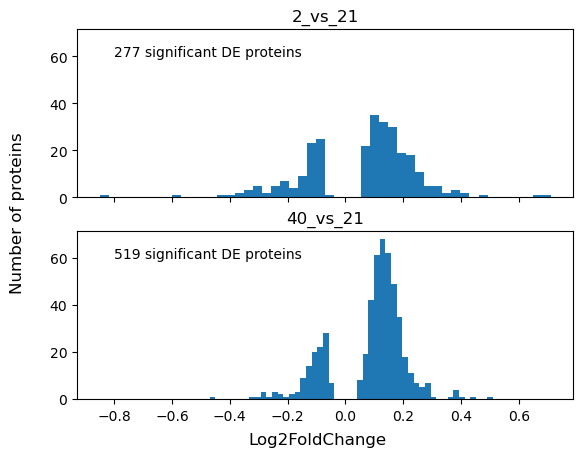

In [12]:
fig, axs = plt.subplots(2, sharex=True, sharey=True)

for comp, ax in zip(comparisons, axs):
    df = comparisons[comp]
    ax.hist(df[df_references[comp]['lfc_name']], bins=50)
    ax.set_title(comp)
    ax.text(-0.8, 60, f'{len(df)} significant DE proteins')

fig.supylabel('Number of proteins')
fig.supxlabel('Log2FoldChange')

## Set operations
We want to know which proteins exhibit opposite behavior at the two conditions.

In [13]:
two_forty = pd.merge(two_vs_21, forty_vs_21, left_on='Accession Number', right_on='Accession Number', suffixes=('_2o2', '_40o2'))
protein_opposites = two_forty[two_forty[two_lfc_name]*two_forty[forty_lfc_name] < 0]
protein_opposites.shape

(21, 85)

Only 21 proteins!

## Comparison to transcriptomic data
We now want to see if any of these proteins overlap with the candidates we saw in our transcriptomic analysis. To do this, we want to map the protein ID's to the TAIR ID's for the associated genes. TAIR provides a conversion file, so let's read that in:

In [14]:
id_map = pd.read_csv('../data/proteomics/TAIR2UniprotMapping.txt', sep='\t', names=['uniprot_id', 'locus', 'TAIR_id']).drop_duplicates() # I don't know why there are so many duplicates in here (where the entire row is identical), but there are and it messes things up later on, so drop here
id_map.head()

,uniprot_id,locus,TAIR_id
0,A0A0A7EPL0-2,locus:2035999,AT1G08910
1,A0A178UFM8,locus:2153097,AT5G51560
2,A0A178VEK7,locus:2103386,AT3G60460
3,A0A178WF56,locus:2205245,AT1G56060
4,A0A1I9LMX5,locus:2098695,AT3G50610


Remove extra characters that are a remnent of the Scaffold GUI:

In [15]:
protein_opposites.loc[:, "Accession Number clean"] = protein_opposites["Accession Number"].str.split('[').str[0].str.strip().str.split('(').str[0].str.strip()

/tmp/local/51487491/ipykernel_3013194/1377209914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_opposites.loc[:, "Accession Number clean"] = protein_opposites["Accession Number"].str.split('[').str[0].str.strip().str.split('(').str[0].str.strip()


Convert:

In [16]:
opposites_with_ids = pd.merge(protein_opposites, id_map, left_on='Accession Number clean', right_on='uniprot_id', how='left')[['Accession Number clean', 'Accession Number', 'TAIR_id', 'locus', two_pval_col_name, two_lfc_name, forty_pval_col_name, forty_lfc_name]]
opposites_with_ids.head()

,Accession Number clean,Accession Number,TAIR_id,locus,Permutation Test (p-value) Benjamini-Hochberg (p < 0.00297),Log? Fold Change by Category (Set 2 / Set 21),Permutation Test (p-value) Benjamini-Hochberg (p < 0.00553),Log? Fold Change by Category (Set 40 / Set 21)
0,O80448,O80448,AT2G38230,locus:2042932,0.00015,0.09,0.00063,-0.08
1,Q38814,Q38814,NaN,NaN,0.00009,0.11,0.00400,-0.07
2,Q9SD76,Q9SD76,AT3G46970,locus:2075576,0.00009,0.18,0.00009,-0.07
3,Q9SAC6,Q9SAC6 [2],AT1G10760,locus:2019953,0.00009,0.07,0.00009,-0.08
4,Q8L940,Q8L940,AT5G01410,locus:2179142,0.00009,0.22,0.00057,-0.09


Now we want to see what genes are here that appear in our transcriptomics candidate sets; we'll use an UpsetPlot to look at the general overlap. First, let's see how many of our differentially expressed genes actually appear in the proteomics dataset; proteomics is much less complete than transcriptomics, so we'd first like to see what genes are represented at all before we check which ones are differentially abundant as proteins.

In [17]:
data_path = '../data/gene_lists_with_descriptions'
transcriptomic_comparisons = {}
for f in listdir(data_path):
    comp = splitext(f)[0]
    transcriptomic_comparisons[comp] = pd.read_csv(f'{data_path}/{f}')

In [18]:
# Map TAIR Id's to the UniProt ID's
tair_all_proteins_arrays = {p: id_map.loc[id_map['uniprot_id'] == p, 'TAIR_id'].values for p in all_proteins}
tair_all_proteins_conversion = {p: [t[0]] if len(t) > 0 else [np.nan] for p, t in tair_all_proteins_arrays.items()}
tair_all_proteins = pd.DataFrame.from_dict(tair_all_proteins_conversion, columns=['TAIR_id'], orient='index')

In [19]:
tair_all_proteins.head()

,TAIR_id
O03042,ATCG00490
B3H5S2,AT5G38410
P19366,ATCG00480
P23321,AT5G66570
P10896,NaN


In [20]:
print(f"{tair_all_proteins.isna().sum().item()} of the {len(all_proteins)} total identified proteins did not get a conversion to a TAIR ID.")

615 of the 4307 total identified proteins did not get a conversion to a TAIR ID.


In [21]:
for comp, df in transcriptomic_comparisons.items():
    overlap = set(df.name_base.tolist()).intersection(set(tair_all_proteins.TAIR_id.dropna().tolist()))
    print(f'Comparison {comp} has {len(overlap)} (of {len(df)}) genes represented in the proteomics dataset. This is {(len(overlap)/len(df))*100:.2f}% of the DEGs in this comparison.')

Comparison 1h_vs_7h_2o2_DEGs_with_descriptions has 429 (of 4023) genes represented in the proteomics dataset. This is 10.66% of the DEGs in this comparison.
Comparison 1h_o2_40_21_DEGs_with_descriptions has 2 (of 100) genes represented in the proteomics dataset. This is 2.00% of the DEGs in this comparison.
Comparison hour7_opposite_behavior_genes has 2 (of 12) genes represented in the proteomics dataset. This is 16.67% of the DEGs in this comparison.
Comparison 7h_o2_40_21_DEGs_with_descriptions has 7 (of 52) genes represented in the proteomics dataset. This is 13.46% of the DEGs in this comparison.
Comparison 1h_vs_7h_21o2_DEGs_with_descriptions has 244 (of 2096) genes represented in the proteomics dataset. This is 11.64% of the DEGs in this comparison.
Comparison 1h_o2_2_21_DEGs_with_descriptions has 3 (of 76) genes represented in the proteomics dataset. This is 3.95% of the DEGs in this comparison.
Comparison 1h_vs_7h_40o2_DEGs_with_descriptions has 466 (of 3681) genes represented 

As would be expected based on the relatively small number of proteins in the dataset, the coverage for proteomics is relatively low. However, encouragingly, the one gene found in all comparisons in the transcriptomics is present in the proteomics dataset (`all_comparisons_opposites` has 100% coverage). Now let's take a look at, of the genes that are represented in the proteomics dataset, which are significantly upregulated in any way in the proteomics.

In [22]:
two_vs_21['Accession Number clean'] = two_vs_21["Accession Number"].str.split('[').str[0].str.strip().str.split('(').str[0].str.strip()
forty_vs_21['Accession Number clean'] = forty_vs_21["Accession Number"].str.split('[').str[0].str.strip().str.split('(').str[0].str.strip()
all_de_proteins = set(two_vs_21['Accession Number clean'].tolist() + forty_vs_21['Accession Number clean'].tolist())
tair_all_de_proteins_arrays = {p: id_map.loc[id_map['uniprot_id'] == p, 'TAIR_id'].values for p in all_de_proteins}
tair_all_de_proteins_conversion = {p: [t[0]] if len(t) > 0 else [np.nan] for p, t in tair_all_de_proteins_arrays.items()}
tair_all_de_proteins = pd.DataFrame.from_dict(tair_all_de_proteins_conversion, columns=['TAIR_id'], orient='index')

In [23]:
print(f"{tair_all_de_proteins.isna().sum().item()} of the {len(all_de_proteins)} total identified DE proteins did not get a conversion to a TAIR ID.")

123 of the 691 total identified DE proteins did not get a conversion to a TAIR ID.


In [24]:
for comp, df in transcriptomic_comparisons.items():
    overlap = set(df.name_base.tolist()).intersection(set(tair_all_de_proteins.TAIR_id.dropna().tolist()))
    print(f'Comparison {comp} has {len(overlap)} (of {len(df)}) genes that are differentially abundant in the proteomics dataset. This is {(len(overlap)/len(df))*100:.2f}% of the DEGs in this comparison.')

Comparison 1h_vs_7h_2o2_DEGs_with_descriptions has 84 (of 4023) genes that are differentially abundant in the proteomics dataset. This is 2.09% of the DEGs in this comparison.
Comparison 1h_o2_40_21_DEGs_with_descriptions has 1 (of 100) genes that are differentially abundant in the proteomics dataset. This is 1.00% of the DEGs in this comparison.
Comparison hour7_opposite_behavior_genes has 1 (of 12) genes that are differentially abundant in the proteomics dataset. This is 8.33% of the DEGs in this comparison.
Comparison 7h_o2_40_21_DEGs_with_descriptions has 3 (of 52) genes that are differentially abundant in the proteomics dataset. This is 5.77% of the DEGs in this comparison.
Comparison 1h_vs_7h_21o2_DEGs_with_descriptions has 47 (of 2096) genes that are differentially abundant in the proteomics dataset. This is 2.24% of the DEGs in this comparison.
Comparison 1h_o2_2_21_DEGs_with_descriptions has 0 (of 76) genes that are differentially abundant in the proteomics dataset. This is 0.

In order to deal with the fact that many of the transcripts' resulting proteins are not present, we're going to remove them for the purpose of the next analysis. We are fundamentally interested in proteins that show the same direction of change in the transcriptome vs. the proteome, but if  protein isn't present in the analysis, then we can exclude it.

In [25]:
transcriptomics_filtered = {}
for comp, df in transcriptomic_comparisons.items():
    overlap = set(df.name_base.tolist()).intersection(set(tair_all_proteins.TAIR_id.dropna().tolist()))
    filtered_df = df[df.name_base.isin(overlap)]
    transcriptomics_filtered[comp] = filtered_df

Wrangling the data for input into UpSetPlot:

In [26]:
two_de = {p: id_map.loc[id_map['uniprot_id'] == p, 'TAIR_id'].values for p in two_vs_21['Accession Number clean'].tolist()}
forty_de = {p: id_map.loc[id_map['uniprot_id'] == p, 'TAIR_id'].values for p in forty_vs_21['Accession Number clean'].tolist()}

two_de = {p: [t[0]] if len(t) > 0 else [np.nan] for p, t in two_de.items()}
forty_de = {p: [t[0]] if len(t) > 0 else [np.nan] for p, t in forty_de.items()}

two_de_df = pd.DataFrame.from_dict(two_de, columns=['TAIR_id'], orient='index')
forty_de_df = pd.DataFrame.from_dict(forty_de, columns=['TAIR_id'], orient='index')

In [27]:
genes_in_comps = {}
for comp, df in transcriptomics_filtered.items():
    genes_in_comps[comp] = list(set(df.name_base.tolist()))
genes_in_comps['proteomics_opposites'] = list(set(opposites_with_ids['TAIR_id'].tolist()))
genes_in_comps['proteomics_2_DE'] = list(set(two_de_df['TAIR_id'].tolist()))
genes_in_comps['proteomics_40_DE'] = list(set(forty_de_df['TAIR_id'].tolist()))
genes_in_comps = dict(sorted(genes_in_comps.items()))

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

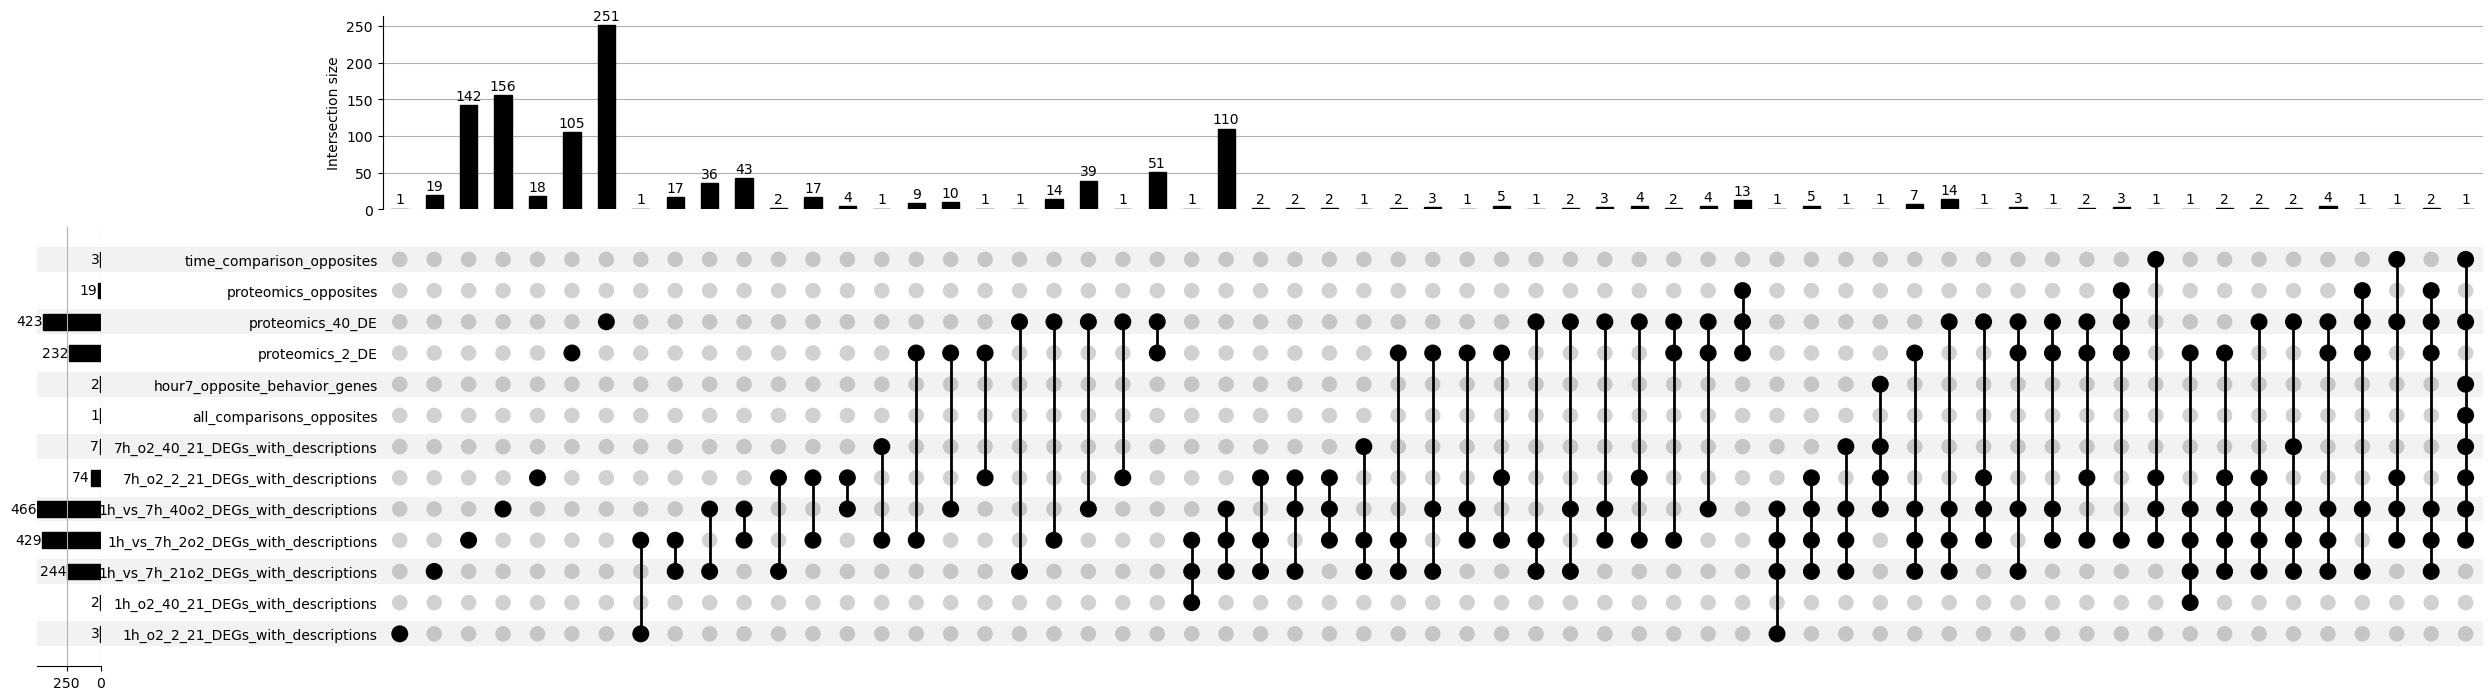

In [28]:
warnings. filterwarnings('ignore') 
to_plot = from_contents(genes_in_comps)
plot(to_plot, show_counts=True, sort_categories_by='input')

We can make this a little more visually simple by just looking for genes with opposite behaviors at the conditions:

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

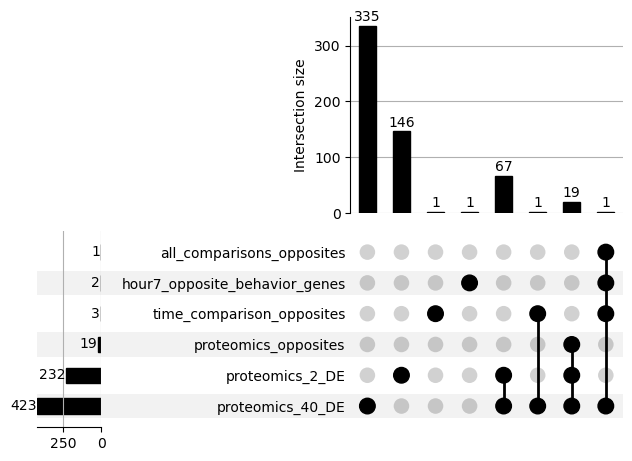

In [29]:
warnings. filterwarnings('ignore') 
keys_to_keep = ['hour7_opposite_behavior_genes', 'all_comparisons_opposites', 'time_comparison_opposites', 'proteomics_opposites', 'proteomics_2_DE', 'proteomics_40_DE']
to_plot = from_contents({k: v for k, v in genes_in_comps.items() if k in keys_to_keep})
plot(to_plot, show_counts=True)

Unfortunately, it looks like our gene of interest from the opposite behavior set operations in transcriptomics doesn't have opposite behaviors in the proteomics dataset, and furthermore is only differentially abundant at 40%. Is it going up or down at 40%?

## Looking for photosynthetic proteins
We also want to see if our photosynthesis proteins are present in the dataset.

In [30]:
with open('../data/photosynthesis_genes/all_photosynthesis_genes.json') as f:
    all_photosynth_genes = json.load(f)

In [34]:
proteomics_genes = {
    'proteomics_opposites': list(set(opposites_with_ids['TAIR_id'].dropna().tolist())),
    'proteomics_2_DE': list(set(two_de_df['TAIR_id'].dropna().tolist())),
    'proteomics_40_DE': list(set(forty_de_df['TAIR_id'].dropna().tolist()))
}

proteomics_genes = {k: [i.lower() for i in v] for k, v in proteomics_genes.items()}
all_photosynth_genes = {k: [i.lower() for i in v] for k, v in all_photosynth_genes.items()}
gene_groups = proteomics_genes
gene_groups.update(all_photosynth_genes)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

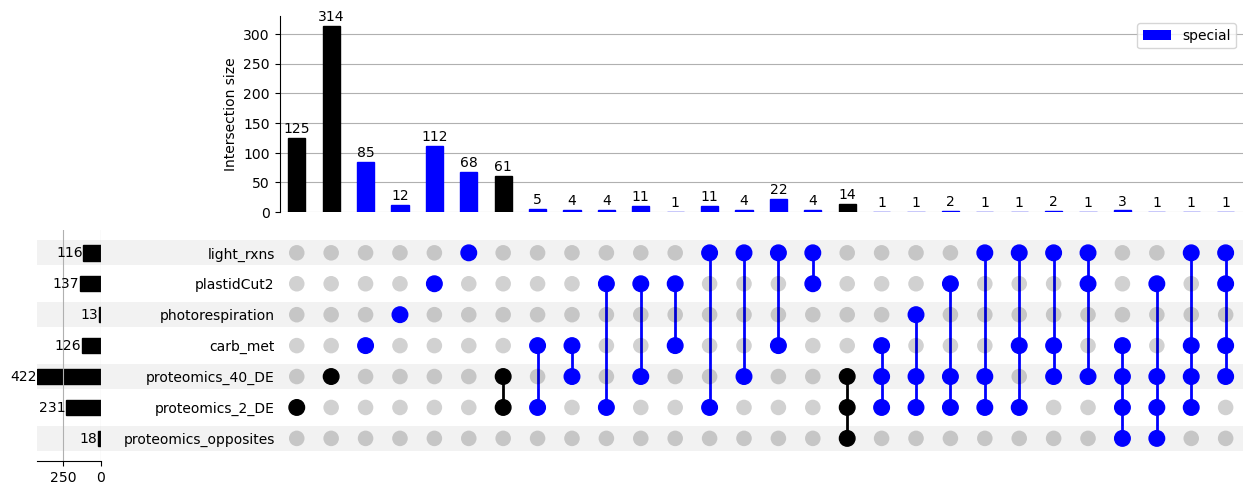

In [40]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(gene_groups)

upset = UpSet(to_plot, show_counts=True, sort_categories_by='input')
for c in all_photosynth_genes.keys():
    upset.style_subsets(present=c, facecolor="blue", label="special")
upset.plot()